# General plan (TBD)
1. Use Pearson's Correlation & Lasso Regression to filter out irrelevant variables.
2. Perform sampling with replacement to generate different subsets of data. Draw subsets with sizes ranging from 100 to 5000, increasing in intervals of 100. Repeat this process 100 times for robustness
3. Standardize each subset, then apply three noise mechanisms (Laplace, Gaussian, and Truncated Laplace) with a fixed ϵ and δ value.
4. Measure and compare accuracy across sample sizes.

# Resources

* Gautam Kamath. (2020). CS 860: Algorithms for Private Data Analysis, Lecture 17
* Geng, Q., Ding, W., Guo, R., & Kumar, S. (2019). Privacy and utility tradeoff in approximate differential privacy. arXiv preprint arXiv:1810.00877v2. Retrieved from https://arxiv.org/abs/1810.00877
* Holohan, N., Leith, D., & Mason, O. (2014). Differential Privacy in Metric Spaces: Numerical, Categorical, and Functional Data Under the One Roof. arXiv preprint arXiv:1402.6124. Retrieved from https://arxiv.org/abs/1402.6124
* Near, J. P., & Abuah, C. (2024). Programming Differential Privacy. Retrieved from https://uvm-plaid.github.io/programming-dp/
* Zoppelletto, L. (2024). Financial Risk for Loan Approval [Data set]. Kaggle. https://www.kaggle.com/datasets/lorenzozoppelletto/financial-risk-for-loan-approval

# 1. Import packages and dataset, and data preprocessing.



In [ ]:
# Import packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, Lasso

from multiprocessing import Pool

In [ ]:
# Import Loan.csv dataset
df = pd.read_csv("Loan.csv")
df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,1/1/2018,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,1/2/2018,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,1/3/2018,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,1/4/2018,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,1/5/2018,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179141,0.070210,1,36.0


In [ ]:
# Check data shape
df.shape

(20000, 36)

In [ ]:
# Drop ApplicationDate column
df = df.drop('ApplicationDate', axis=1)

# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         20000 non-null  int64  
 1   AnnualIncome                20000 non-null  int64  
 2   CreditScore                 20000 non-null  int64  
 3   EmploymentStatus            20000 non-null  object 
 4   EducationLevel              20000 non-null  object 
 5   Experience                  20000 non-null  int64  
 6   LoanAmount                  20000 non-null  int64  
 7   LoanDuration                20000 non-null  int64  
 8   MaritalStatus               20000 non-null  object 
 9   NumberOfDependents          20000 non-null  int64  
 10  HomeOwnershipStatus         20000 non-null  object 
 11  MonthlyDebtPayments         20000 non-null  int64  
 12  CreditCardUtilizationRate   20000 non-null  float64
 13  NumberOfOpenCreditLines     200

In [ ]:
# Assign features and label
X = df.drop('LoanApproved', axis=1)
y = df['LoanApproved']

# Label encoding 'object' type features
le = LabelEncoder()
for cols in X.select_dtypes('object').columns:
    X[cols] = le.fit_transform(X[cols])

# Display and check features
X.head(5)

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore
0,45,39948,617,0,4,22,13152,48,1,2,...,19183,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,49.0
1,38,39709,628,0,0,15,26045,48,2,1,...,9595,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,52.0
2,47,40724,570,0,1,26,17627,36,1,2,...,128874,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,52.0
3,58,69084,545,0,3,34,37898,96,2,1,...,5370,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,54.0
4,37,103264,594,0,0,17,9184,36,1,1,...,17286,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179141,0.070210,36.0


## Using Pearson's Correlation and Lasso Regression to do feature selection



In [ ]:
# Calculate the Pearson's correlation matrix
corr = X.corr().abs().unstack().sort_values(ascending=False)

# Filter out self-correlations
high_correlation_pairs = corr[corr < 1].drop_duplicates()

# Check for pairs with correlation above 0.75
high_correlation_pairs = high_correlation_pairs[high_correlation_pairs > 0.75]
print(high_correlation_pairs)

MonthlyIncome       AnnualIncome        0.989911
Age                 Experience          0.982980
TotalAssets         NetWorth            0.978997
InterestRate        BaseInterestRate    0.834557
MonthlyLoanPayment  LoanAmount          0.780828
dtype: float64


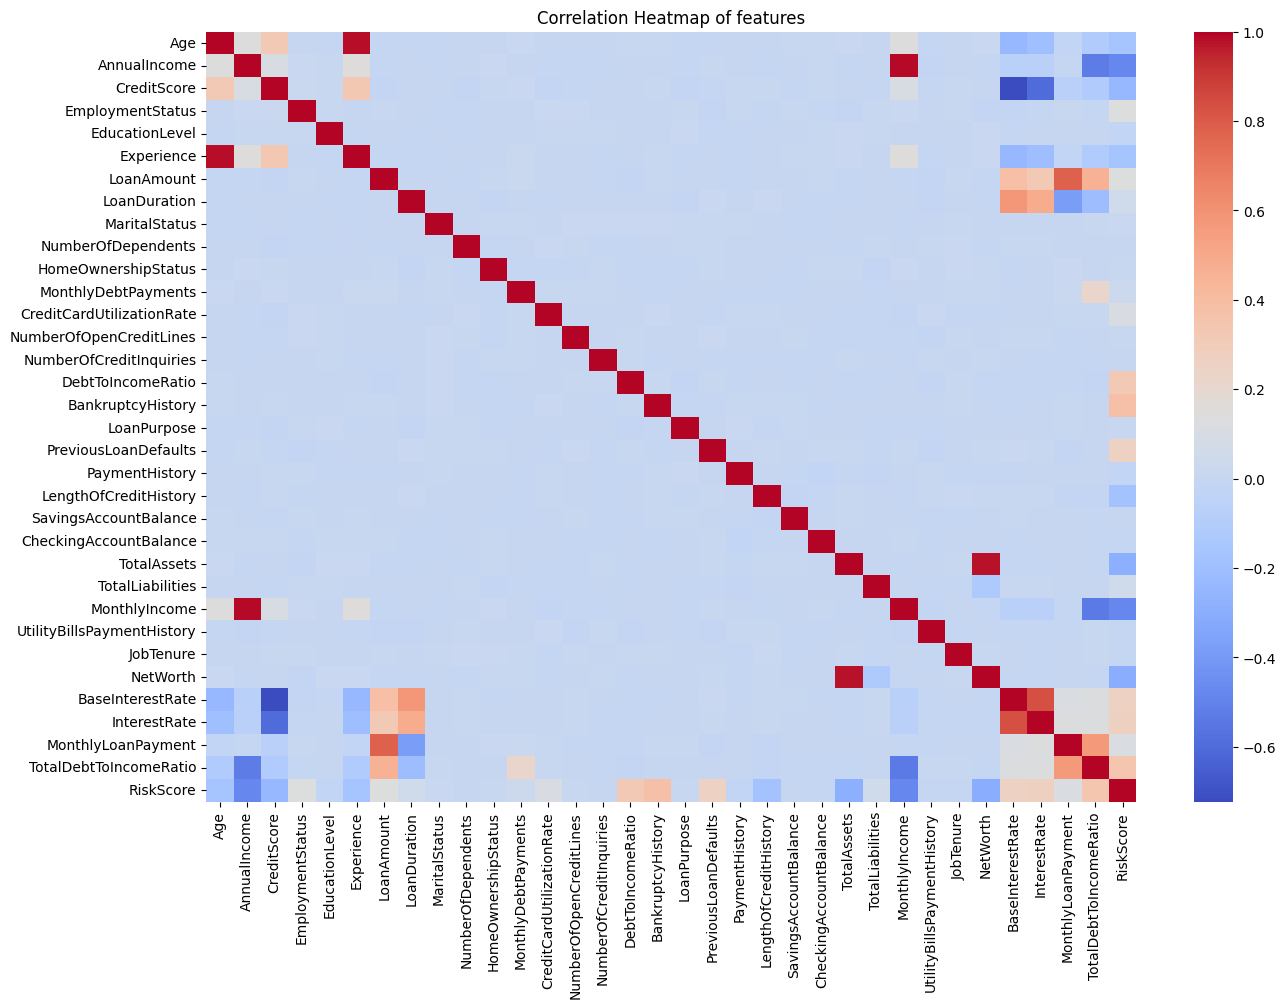

In [ ]:
# Visualize correlation using heatmap (Optional)
plt.figure(figsize=(15,10))
sns.heatmap(X.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap of features")
plt.show()

In [ ]:
# Remove one feature from each pair with high correlation
X = X.drop(['MonthlyIncome', 'Experience', 'NetWorth', 'BaseInterestRate', 'MonthlyLoanPayment'], axis=1)
X.shape

(20000, 29)

In [ ]:
# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use LassoCV for feature selection
lasso_cv = Lasso()
lasso_cv.fit(X_train, y_train)
X_selected = X_train.columns[lasso_cv.coef_ != 0]
X = X[X_selected]
X.head(5)

,AnnualIncome,CreditScore,LoanAmount,MonthlyDebtPayments,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,NetWorth,MonthlyLoanPayment,RiskScore
0,39948,617,13152,183,7632,1202,146111,19183,3329.000000,126928,419.805992,49.0
1,39709,628,26045,496,4627,3460,53204,9595,3309.083333,43609,794.054238,52.0
2,40724,570,17627,902,886,895,25176,128874,3393.666667,5205,666.406688,52.0
3,69084,545,37898,755,1675,1217,104822,5370,5757.000000,99452,1047.506980,54.0
4,103264,594,9184,274,1555,4981,244305,17286,8605.333333,227019,330.179141,36.0


In [ ]:
df_stand = pd.concat([X, y],axis = 1)
#df_stand.head(5)
df_stand.to_csv('data_selected.csv',index=False)

# 2. Sampling

In [ ]:
## Import Dataset (After Feature Selection) (9 attributes and a response variable)
df_sub = pd.read_csv("data_selected.csv")
df_sub.head()

,AnnualIncome,CreditScore,LoanAmount,MonthlyDebtPayments,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,RiskScore,LoanApproved
0,39948,617,13152,183,7632,1202,146111,19183,49.0,0
1,39709,628,26045,496,4627,3460,53204,9595,52.0,0
2,40724,570,17627,902,886,895,25176,128874,52.0,0
3,69084,545,37898,755,1675,1217,104822,5370,54.0,0
4,103264,594,9184,274,1555,4981,244305,17286,36.0,1


In [ ]:
## Bootstrapping Function
def bootstrap_sample(data, n_bootstrap):
    # List to store each bootstrap sample DataFrame with an additional identifier
    bootstrap_samples = []
    # Sample indices with replacement
    sample_indices = np.random.choice(data.index, size=n_bootstrap, replace=True)
    # Get the bootstrap sample and add a 'sample_id' to identify it
    sample = data.loc[sample_indices] .copy()
    # Append to the list of samples
    bootstrap_samples = sample

    return bootstrap_samples

# 3. Establish baseline by running Logistic Regression on base dataset without DP.

In [ ]:
## Logistic regression which return the accuracy
def accuracy_logistic(dataset):
  X_sample = dataset[0]
  y_sample = dataset[1]

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

  # Initialize and train the logistic regression model
  model = LogisticRegression(max_iter=4000)
  model.fit(X_train, y_train)

  # Make predictions and evaluate
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

In [ ]:
# Run Logistic Regression on baseline data
sample_sizes = list(range(100, 5001, 100))
results_baseline = []

for n in sample_sizes:
  n_bootstrap = n
  bootstrap_results = []
  for i in range(100):
    np.random.seed(1234+i)
    sample = bootstrap_sample(df_sub, n_bootstrap)
    X = sample.drop('LoanApproved', axis=1)
    y = sample['LoanApproved']
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    sample_x = np.array(X)
    sample_y = np.array(y)
    bootstrap_results.append([sample_x,sample_y])

  if __name__ == '__main__':
    with Pool() as p:
        acc = p.map(accuracy_logistic, bootstrap_results)
        accuracy = np.mean(acc)
        results_baseline.append({'sample_size': n,'accuracy': accuracy})

In [ ]:
# Save results
Baseline_repeat_mean = pd.DataFrame(results_baseline, columns=["sample_size","accuracy"])
# print(Baseline_repeat_mean.head())
Baseline_repeat_mean.to_csv('baseline_repeat_100.csv',index=True)

# 4. Modify dataset with **Laplace (ϵ)-DP Mechanism**
Add Laplace noise to the base dataset and train the model again. Compute evaluation metrics



In [ ]:
# Define a function to add Laplace noise with feature-specific sensitivity
def dp_laplace(value, epsilon=1):

    # Calclate sensitivity by taking the max - min of input value
    sensitivity = value.max() - value.min()

    # Scale parameter for the Laplace distribution
    scale = sensitivity / epsilon

    # Generate Laplace noise
    np.random.seed(1234)
    noise = np.random.laplace(loc=0, scale=scale, size=value.shape)

    # Return the noisy value
    return value + noise

In [ ]:
def randomized_response(data, probability_of_truth=0.5):
    # Create a copy of the array to store responses
    randomized_data = data.copy()

    # Apply randomized response to each element
    for i in range(len(randomized_data)):
        # Randomly decide whether to answer truthfully or randomly
        if np.random.rand() < probability_of_truth:
            # Answer truthfully
            response = data[i]
        else:
            # Random response (0 or 1) assuming binary data
            response = np.random.choice([0, 1])

        randomized_data[i] = response

    return randomized_data

In [ ]:
# Apply Laplace mechanism (epsilon = 1) to dataset and run Logistic Regression
sample_sizes = list(range(100, 5001, 100))
results_laplace_epsilon = []

for n in sample_sizes:
  n_bootstrap = n
  bootstrap_results = []
  for i in range(100):
    np.random.seed(1234+i)
    sample = bootstrap_sample(df_sub, n_bootstrap)
    X = sample.drop('LoanApproved', axis=1)
    y = sample['LoanApproved']
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    sample_x = np.array(X)
    sample_y = np.array(y)

    ## Add noise (Laplace Mechanism)
    X_laplace = sample_x.copy()
    trans_sample_x = np.transpose(X_laplace)

    for i in range(len(trans_sample_x)):
          trans_sample_x[i] = dp_laplace(trans_sample_x[i],epsilon=1)

    trans_sample_x = np.transpose(trans_sample_x)

    ## Add noise to y
    epsilon=1
    p = math.exp(epsilon) / (math.exp(epsilon) + 1)
    new_y = np.array(randomized_response(sample_y, probability_of_truth=p))

    bootstrap_results.append([trans_sample_x,new_y])


  if __name__ == '__main__':
    with Pool() as p:
        acc = p.map(accuracy_logistic, bootstrap_results)
        accuracy = np.mean(acc)
        results_laplace_epsilon.append({'sample_size': n,'accuracy': accuracy})
        # print(acc)

In [ ]:
# Save results
laplace_ep_repeat_mean = pd.DataFrame(results_laplace_epsilon, columns=["sample_size","accuracy"])
# print(laplace_ep_repeat_mean)
laplace_ep_repeat_mean.to_csv('laplace_ep_repeat_100.csv',index=True)

# 5. Modify dataset with **Truncated Laplace (ϵ,δ)-DP Mechanism**
Add Truncated Laplace noise with other parameter, δ, to the base dataset and train the model again. Compute evaluation metrics

In [ ]:
# Define Truncated Laplace sampler (reference linked at the top of the notebook)
class TruncatedLaplaceSampler:
    def __init__(self, epsilon, delta, Delta):
        self.epsilon = epsilon
        self.delta = delta
        self.Delta = Delta

        # Precalculate constants to avoid repeated calculations
        self.lambda_param = self.Delta / self.epsilon
        exp_epsilon = np.exp(epsilon)
        temp = (exp_epsilon - 1) / (2 * delta)

        self.A = self.lambda_param * np.log(1 + temp)
        self.B = 1 / (2 * self.lambda_param * (1 - 1 / (1 + temp)))

    def appro_cdf(self, sample_pdf):
        left = np.full_like(sample_pdf, -self.A)
        right = np.full_like(sample_pdf, self.A)

        for _ in range(20):  # Fixed number of iterations instead of while loop
            mid = (left + right) / 2
            mask = self._cdf(mid) > sample_pdf
            right = np.where(mask, mid, right)
            left = np.where(mask, left, mid)

        return (left + right) / 2

    def sample(self, size=1):
        np.random.seed(1234)
        u = np.random.uniform(0, 1, size=size)
        return self.appro_cdf(u)

    def _cdf(self, x):
        x = np.asarray(x)
        result = np.zeros_like(x, dtype=float)

        # Create masks for each condition
        mask_less = x < -self.A
        mask_greater = x > self.A
        mask_positive = (x >= 0) & (x <= self.A)
        mask_negative = (x < 0) & (x >= -self.A)

        # Apply each condition
        result[mask_less] = 0
        result[mask_greater] = 1

        # Positive x values
        x_pos = x[mask_positive]
        if len(x_pos) > 0:
            result[mask_positive] = 0.5 + self.lambda_param * self.B * (1 - np.exp(-np.abs(x_pos) / self.lambda_param))

        # Negative x values
        x_neg = x[mask_negative]
        if len(x_neg) > 0:
            result[mask_negative] = 1 - (0.5 + self.lambda_param * self.B * (1 - np.exp(-np.abs(x_neg) / self.lambda_param)))

        return result

def dp_truncated_laplace(value, epsilon=1, delta=1e-5):
    sensitivity = np.ptp(value)  # Faster than max() - min()

    sampler = TruncatedLaplaceSampler(
        epsilon=epsilon,
        delta=delta,
        Delta=sensitivity
    )

    noise = sampler.sample(size=len(value))
    return value + noise

def process_bootstrap(args):
    i, n_bootstrap, df_sub = args
    np.random.seed(1234 + i)

    # Bootstrap sampling
    sample = bootstrap_sample(df_sub, n_bootstrap)
    X = sample.drop('LoanApproved', axis=1)
    y = sample['LoanApproved']

    # Scale features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    sample_x = np.array(X)
    sample_y = np.array(y)

    # Add noise to features
    X_noisy = sample_x.copy()
    trans_sample_x = np.transpose(X_noisy)

    for j in range(len(trans_sample_x)):
        trans_sample_x[j] = dp_truncated_laplace(trans_sample_x[j], epsilon=1, delta=1e-5)

    trans_sample_x = np.transpose(trans_sample_x)

    # Add noise to labels
    epsilon = 1
    p = math.exp(epsilon) / (math.exp(epsilon) + 1)
    new_y = np.array(randomized_response(sample_y, probability_of_truth=p))

    return accuracy_logistic([trans_sample_x, new_y])

# Apply Truncated Laplace mechanism (epsilon = 1, delta = 0.00001) to dataset and run Logistic Regression
if __name__ == '__main__':
    sample_sizes = list(range(100, 5001, 100))
    results_truncated_laplace = []

    # Use a single Pool for all processing
    with Pool() as pool:
        for n in sample_sizes:
            # Prepare arguments for parallel processing
            args = [(i, n, df_sub) for i in range(100)]

            # Process all bootstrap samples in parallel
            accuracies = pool.map(process_bootstrap, args)

            # Calculate mean accuracy
            accuracy = np.mean(accuracies)
            results_truncated_laplace.append({
                'sample_size': n,
                'accuracy': accuracy
            })

In [ ]:
# Save results
truncated_laplace_repeat_mean = pd.DataFrame(results_truncated_laplace, columns=["sample_size","accuracy"])
# print(truncated_laplace_repeat_mean)
truncated_laplace_repeat_mean.to_csv('truncated_laplace_repeat_100.csv',index=True)

# 6. Modify dataset with Gaussian (ϵ,δ)-DP Mechanism
Add Gaussian noise to the base dataset and train the model again. Compute evaluation metrics

In [ ]:
# Define Gaussian mechanism with default epsilon = 1 and delta = 0.00001
def dp_gaussian(value, epsilon=1, delta=1e-5):
    # L2 sensitivity
    sensitivity = np.linalg.norm(value, ord=2)

    # scale for gaussian
    scale = np.sqrt(2 * np.log(1.25 / delta)) * (sensitivity / epsilon)

    np.random.seed(1234)
    noise = np.random.normal(loc=0, scale=scale, size=value.shape)

    return value + noise

In [ ]:
# Apply Gaussian mechanism (epsilon = 1, delta = 0.00001) to dataset and run Logistic Regression
sample_sizes = list(range(100, 5001, 100))
results_gaussian_epsilon = []

for n in sample_sizes:
    n_bootstrap = n
    bootstrap_results = []
    for i in range(100):
        np.random.seed(1234+i)
        sample = bootstrap_sample(df_sub, n_bootstrap)
        X = sample.drop('LoanApproved', axis=1)
        y = sample['LoanApproved']
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        sample_x = np.array(X)
        sample_y = np.array(y)

        ## Add noise (Gaussian Mechanism)
        X_gaussian = sample_x.copy()
        trans_sample_x = np.transpose(X_gaussian)

        for i in range(len(trans_sample_x)):
            trans_sample_x[i] = dp_gaussian(trans_sample_x[i],epsilon=1)

        trans_sample_x = np.transpose(trans_sample_x)

        ## Add noise to y
        epsilon=1
        p = math.exp(epsilon) / (math.exp(epsilon) + 1)
        new_y = np.array(randomized_response(sample_y, probability_of_truth=p))

        bootstrap_results.append([trans_sample_x,new_y])

    if __name__ == '__main__':
        with Pool() as p:
            acc = p.map(accuracy_logistic, bootstrap_results)
            accuracy = np.mean(acc)
            results_gaussian_epsilon.append({'sample_size': n,'accuracy': accuracy})
            # print(acc)

In [ ]:
# Save results
gaussian_ep_repeat_mean = pd.DataFrame(results_gaussian_epsilon, columns=["sample_size","accuracy"])
# print(gaussian_ep_repeat_mean)
gaussian_ep_repeat_mean.to_csv('gaussian_ep_repeat_100_L2.csv',index=True)

# 7. Plot results

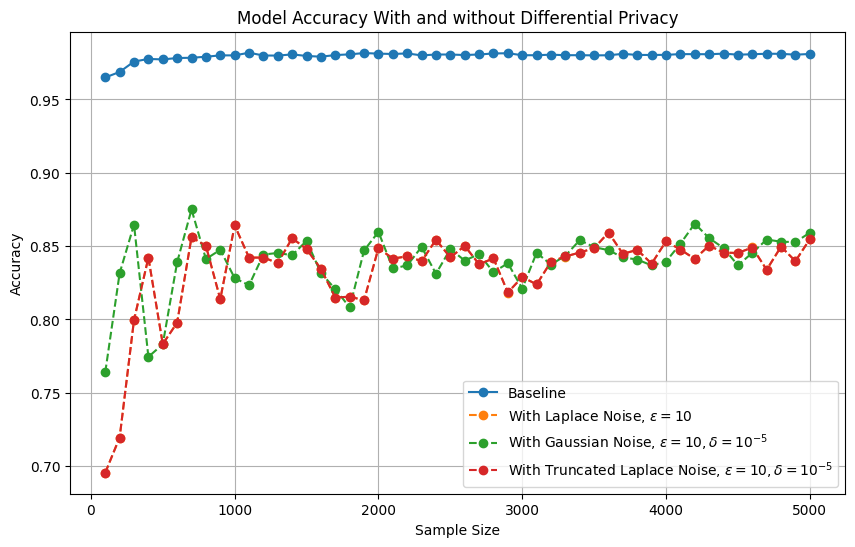

In [ ]:
# Sample sizes and accuracy results (replace with actual values if available)
baseline = pd.read_csv("baseline_repeat_100.csv")
laplace = pd.read_csv("laplce_ep_repeat_100.csv")
truncated_lap = pd.read_csv("truncated_laplace_repeat_100.csv")
gaussian = pd.read_csv("gaussian_ep_repeat_100.csv")
# dpsgd = pd.read_csv("dpsgd_ep_repeat_100_NEW.csv")

accuracies_baseline = list(baseline['accuracy'])
accuracies_laplace = list(laplace['accuracy'])
accuracies_ truncated = list(truncated_lap['accuracy'])
accuracies_gaussian = list(gaussian['accuracy'])
# accuracies_dpsgd = list(dpsgd_ep['accuracy'])


# Plotting the line chart
plt.figure(figsize=(10, 6))
sample_sizes = list(range(100, 5001, 100))
plt.plot(sample_sizes, accuracies_baseline, marker='o', label="Baseline")
plt.plot(sample_sizes, accuracies_laplace, marker='o', linestyle='--', label="With Laplace Noise, "+ r"$\epsilon=10$")
plt.plot(sample_sizes, accuracies_truncated, marker='o', linestyle='--', label="With Truncated Laplace Noise, "+ r"$\epsilon=10, \delta = 10^{-5}$")
plt.plot(sample_sizes, accuracies_gaussian, marker='o', linestyle='--', label="With Gaussian Noise, "+ r"$\epsilon=10, \delta = 10^{-5}$")
# plt.plot(sample_sizes, accuracies_dpsgd, marker='o', linestyle='--', label="With dpsgd_ep Noise")

# Adding labels and title
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.title("Model Accuracy With and without Differential Privacy")
plt.legend()
plt.grid(True)
plt.show()

# (Additional) Modify dataset with Differentially Private Stochastic Gradient Descent (DP-SGD)
Add DP-SGD noise to the base dataset and train the model again. Compute evaluation metrics

In [ ]:
# Save results
dpsgd_ep_repeat_mean = pd.DataFrame(results_dp_sgd, columns=["sample_size","accuracy"])
# print(dpsgd_ep_repeat_mean)
dpsgd_ep_repeat_mean.to_csv('dpsgd_ep_repeat_100_NEW.csv',index=True)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def compute_noise_scale(epsilon, delta, l2_norm_clip):
    return (np.sqrt(2 * np.log(1.25 / delta)) * l2_norm_clip) / epsilon

def clip_gradients(gradients, l2_norm_clip):
    grad_norm = np.linalg.norm(gradients)
    if grad_norm > l2_norm_clip:
        gradients = gradients * l2_norm_clip / grad_norm
    return gradients

def dp_sgd_train(X, y, epsilon, delta, learning_rate=0.01, n_epochs=100, batch_size=32, l2_norm_clip=1.0):

    n_samples, n_features = X.shape

    # Initialize weights and bias
    weights = np.zeros(n_features)
    bias = 0

    # Compute noise scale
    noise_scale = compute_noise_scale(epsilon, delta, l2_norm_clip)

    # Training loop
    for epoch in range(n_epochs):
        # Shuffle the data
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Mini-batch training
        for i in range(0, n_samples, batch_size):
            batch_X = X_shuffled[i:i + batch_size]
            batch_y = y_shuffled[i:i + batch_size]
            batch_size_actual = len(batch_X)

            # Forward pass
            logits = np.dot(batch_X, weights) + bias
            predictions = sigmoid(logits)

            # Compute gradients
            error = predictions - batch_y
            grad_w = np.dot(batch_X.T, error) / batch_size_actual
            grad_b = np.mean(error)

            # Clip gradients
            grad_w = clip_gradients(grad_w, l2_norm_clip)
            grad_b = np.clip(grad_b, -l2_norm_clip, l2_norm_clip)

            # Add noise
            grad_w += np.random.normal(0, noise_scale, grad_w.shape)
            grad_b += np.random.normal(0, noise_scale)

            # Update weights
            weights -= learning_rate * grad_w
            bias -= learning_rate * grad_b

    return weights, bias

def dp_sgd_predict(X, weights, bias):
    scores = np.dot(X, weights) + bias
    probs = sigmoid(scores)
    return (probs >= 0.5).astype(int)

def accuracy_dp_logistic(args):
    dataset, epsilon, delta = args
    X_sample = dataset[0]
    y_sample = dataset[1]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

    # Train the DP-SGD model with provided epsilon and delta
    weights, bias = dp_sgd_train(X_train, y_train,
                                epsilon=epsilon,
                                delta=delta,
                                learning_rate=0.01,
                                n_epochs=100,
                                batch_size=32,
                                l2_norm_clip=1.0)

    # Make predictions
    y_pred = dp_sgd_predict(X_test, weights, bias)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
# Example usage with your bootstrap framework:
sample_sizes = list(range(100, 5001, 100))
results_dp_sgd = []

# Privacy parameters can now be set from outside
epsilon = 1.0  # Set your desired epsilon
delta = 1e-5   # Set your desired delta

for n in sample_sizes:
    n_bootstrap = n
    bootstrap_results = []
    for i in range(100):
        np.random.seed(1234+i)
        sample = bootstrap_sample(df_sub, n_bootstrap)
        X = sample.drop('LoanApproved', axis=1)
        y = sample['LoanApproved']
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        sample_x = np.array(X)
        sample_y = np.array(y)

        # Now include epsilon and delta in the bootstrap results
        bootstrap_results.append(([sample_x, sample_y], epsilon, delta))

    if __name__ == '__main__':
        with Pool() as p:
            acc = p.map(accuracy_dp_logistic, bootstrap_results)
            accuracy = np.mean(acc)
            results_dp_sgd.append({
                'sample_size': n,
                'accuracy': accuracy,
                'epsilon': epsilon,
                'delta': delta
            })